In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env, get_label_with_context

from model import (
    get_dynamic_unet, get_resnet50,
    accuracy_segmentation, tensorboard_cb, 
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

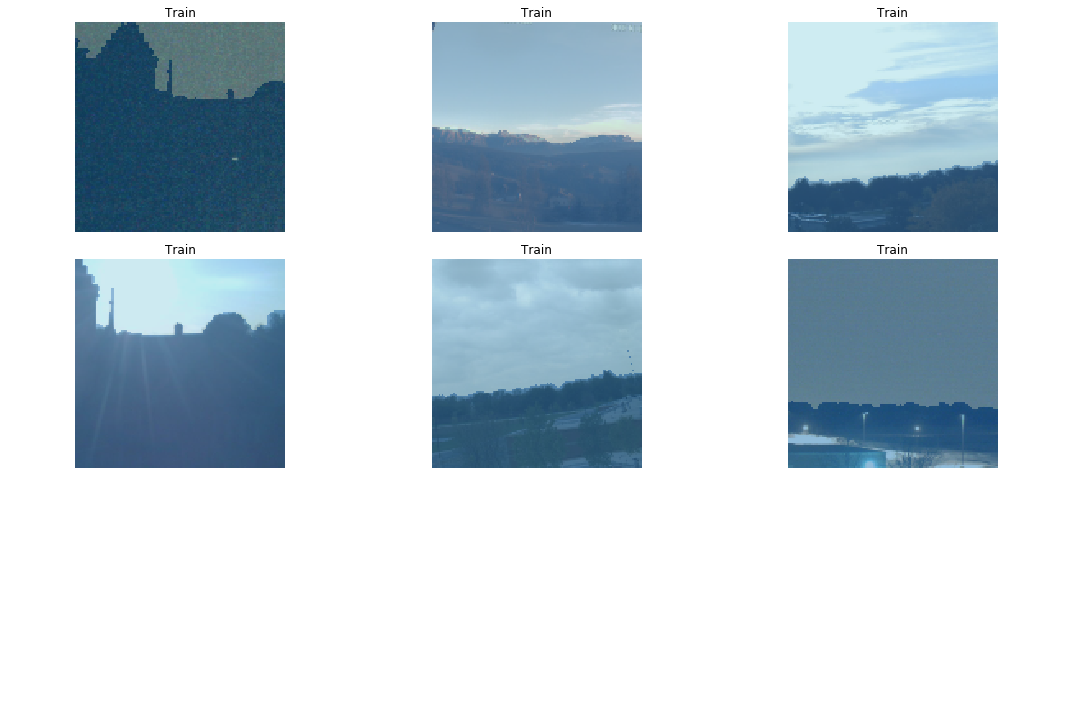

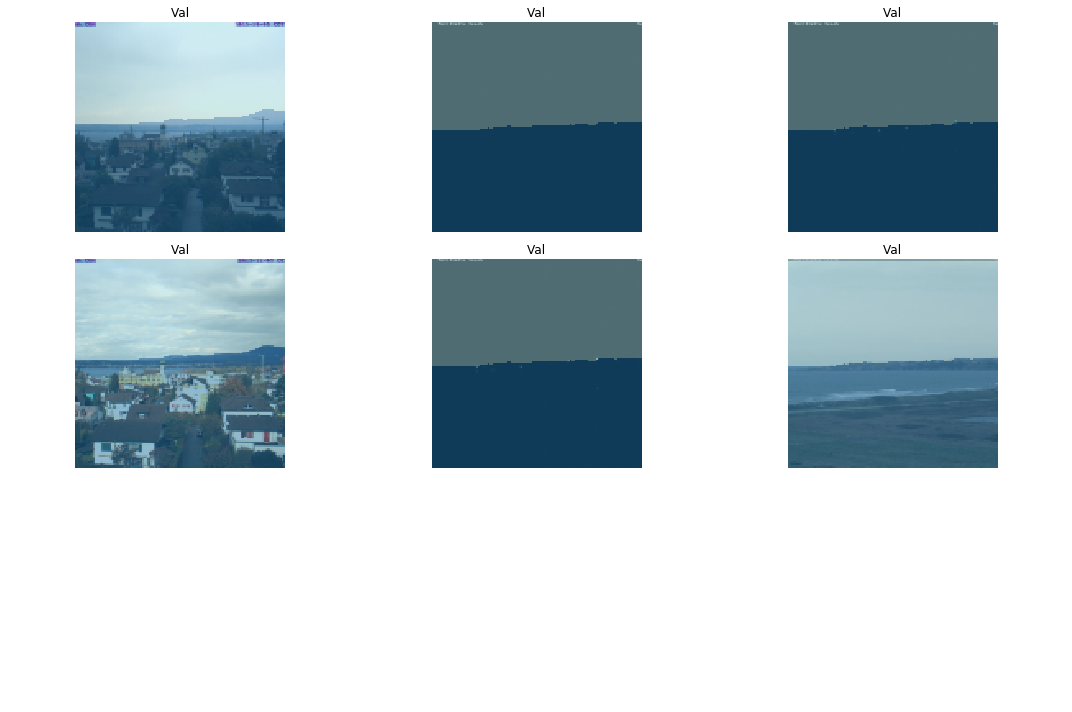

In [6]:
sizes = 128

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train", "val")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=6)
    .normalize(imagenet_stats)
)
classes = train_data.c

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [7]:
model = get_dynamic_unet(get_resnet50(), num_classes=classes, sizes=sizes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()
learner.metrics = [accuracy_segmentation]

learner.freeze_to(1)

In [8]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="unetd_ocp_upsmplT_s128_mlr5e1")

In [9]:
learner.fit_one_cycle(17, max_lr=5e-01, callbacks=[tb_callback(learner)])
learner.save("/home/dmitri/Documents/model_weights/unet34/")
learner.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy_segmentation,time
0,0.092942,3037.961182,0.839600,12:56


KeyboardInterrupt: 